## W207 Final Project: Predicting Song Success

Instructor: Cornelia Ilin <br>
Team Members: Tyler Chi, Raghav Kaushik, Michael Townsend

---
#### ``Baseline Presentation:``
**1.  What is the question you will be working on? Why is it interesting?** <br>
The question we will be working on is identifying what traits make a song stay on top 200 charts the longest?  Given a set of known features about a song, can we predict if it will land on the top 200 and if so for how long?  This question is interesting because artists could potentially use it to determine the style of songs to write and when to come out with those songs for the highest success.  Factors to study could include Day of the Week, Time of Year (Season), Spotify Song Features, & Artist # of Followers. <br>

**2.  What is the data you will be using? Include data source, size of dataset, main features to be used. Summarize the statistics of your data.** <br>
The data we will be using is Spotify data from 2017 to 2020 from 2 sources on Kaggle:

Spotify Charts: https://www.kaggle.com/datasets/dhruvildave/spotify-charts 
Spotify Artists/Tracks: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv 

Three Primary Data Sets from these sources:

artists.csv: 1162095 rows, Main Features to be used --> artist name, popularity, and number of followers.  We'd use this file to merge the Artist # of Followers onto the Song Dataset using Artist name to add that metric to our analysis.

charts.csv: 26173514 rows. Main Features to be used --> Date, # of Streams on Top 200, Chart Rank, Time on Chart.  We'd use this file to label the success of each song we study.  

tracks.csv: 586672 rows. this has information that Spotify generated, characterizing various songs with continuous data (loudness, energy, danceability), as well as some discrete data (key, time_signature). To make this data easier to use in our models, we will apply Standardization to all of the continuous parameters.  For the discrete data we will create one-hot encodings.

<br>

**3.  What prediction algorithms do you plan to use? Please describe them in detail.** <br>
We plan to try a mix of classification & regression models to approach this problem.

First, we will use a Feedforward Neural Network to predict whether any song coming out between 2017 and 2021 will land on the top 200.

Second, we will use the data that does hit the top 200 and predict using linear regression & gradient descent how many streams a given song will have while on the top 200.

This will give the artist a way to predict not only what features it takes to get on the chart, but also how to stay on the chart and reach a platinum record status.

For our baseline models we will use just use the Artist # of Followers:

- Artist # of Followers

For our full models we will use the Artist # of Followers along w/ time features along and the Spotify Song Features:

- Artist # of Followers
- Date of Release
- Day of Week of Release
- Time of Year (Season) of Release
- *12 Song Features:* Duration, Danceability, Energy, Loudness, Key, Speechiness, Acoustiness, Instrumentalness, Liveness, Valence, Tempo, Time Signature

Since some of our data is time-based, we plan to perform a non-random split between train and test sets in order to make sure our model is predictive of new data.

The success metrics we will be predicting for the two models will be:

1. Binary Classification --> Top 200 or not?
2. Regression --> # of Streams on Top 200 Charts within X weeks/months of release
<br>

**4. How will you evaluate your results? Please describe your chosen performance metrices and/or statistical tests in detail.** <br>

To evaluate our first Model (Classification using a Feed-Forward Nueral Network) we will use the following:

- Loss, Accuracy, Precision, Recall, Sensitivity, Specificity, F1 Score

We plan to test out different combinations of layers in our neural net (using Keras/Tensorflow) to optimize accuracy on the test dataset.  We'll also assess the other metrics that are typically assessed when evaluating a classification problem.

To evaluate our second Model (Linear Regression) we will use the following:

- Mean Squared Error, R Squared

We plan to use Keras/Tensorflow and run the model at different learning rates to find the optimal mean squared error.

We plan to make comparisons of our baseline model vs. our optimized model for each of the 4 seasons to see if the additional features from the song & time of year make the model more predictive than just using the artist # of followers alone. <br>

In [40]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime
from datetime import date, timedelta
import numpy as np

In [2]:
# import dataframe
df = pd.read_csv('~/W207/W207_Final_Project/Spotify_Charts/charts.csv')

In [3]:
df.columns

Index(['title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend',
       'streams'],
      dtype='object')

In [4]:
df.head(5)

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [5]:
df2 = pd.read_csv('~/W207/W207_Final_Project/Spotify_Tracks/artists.csv')
df3 = pd.read_csv('~/W207/W207_Final_Project/Spotify_Tracks/tracks.csv')

In [6]:
fav_artists = df2.query('name == "Ed Sheeran" | name == "Ben Platt" | name == "Josh Groban" | name == "Dave Matthews"')
fav_artists.head(5)

,id,followers,genres,name,popularity
100018,13vQloYd6mP7V1mVwKJwS2,278606.0,['pop rock'],Dave Matthews,57
143754,6cXMpsP9x0SH4kFfMyVezF,671658.0,"['adult standards', 'operatic pop']",Josh Groban,65
144138,6eUKZXaKkcviH0Ku9w2n3V,78900234.0,"['pop', 'uk pop']",Ed Sheeran,92
213007,6qGkLCMQkNGOJ079iEcC5k,356372.0,"['hollywood', 'pop', 'post-teen pop', 'show tu...",Ben Platt,71


In [7]:
df3.head(10)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.227,0.2610,5,-12.343,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4
6,0Dd9ImXtAtGwsmsAD69KZT,La Butte Rouge,0,134467,0,['Francis Marty'],['2nuMRGzeJ5jJEKlfS7rZ0W'],1922,0.510,0.3550,4,-12.833,1,0.1240,0.965,0.000000,0.1550,0.7270,85.754,5
7,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,['Mistinguett'],['4AxgXfD7ISvJSTObqm4aIE'],1922,0.563,0.1840,4,-13.757,1,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3
8,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,0,310073,0,['Greg Fieler'],['5nWlsH5RDgFuRAiDeOFVmf'],1922,0.488,0.4750,0,-16.222,0,0.0399,0.620,0.006450,0.1070,0.5440,139.952,4
9,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,181173,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-29,0.548,0.0391,6,-23.228,1,0.1530,0.996,0.933000,0.1480,0.6120,75.595,3


In [20]:
## Parse Tracks file down to last 3 years
df3['release_date'] = pd.to_datetime(df3['release_date'])
recent_tracks_df = df3.query('release_date > "2017-01-01" & release_date < "2021-01-01"')

## Filter Charts file down to US and Top 200
top_200_charts_US = df.query('region == "United States" & chart == "top200"')

364184

In [24]:
## Run Tylers function to generate the Top 200 US Charts w/ Track ID for Merging
def get_track_id_from_url(row):
    url = row['url']
    try:
        return url.split('/')[-1]
    except:
        return ""
#Note: this probably takes like 5 minutes
top_200_charts_US['track_id'] = top_200_charts_US.apply(get_track_id_from_url, axis=1)
top_200_charts_US.to_csv("top_200_US_charts_w_track_id.csv")

<ipython-input-24-ff1415452b8f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_200_charts_US['track_id'] = top_200_charts_US.apply(get_track_id_from_url, axis=1)


In [25]:
top_200_track_id_set = set()
for track_id in top_200_charts_US['track_id'].values:
    top_200_track_id_set.add(track_id)

In [26]:
# determine if a song has appeared in the top 200s
def get_top_200_presence(row):
    track_id = row['id']
    return bool(track_id in top_200_track_id_set)

In [27]:
recent_tracks_df['top_200_presence'] = recent_tracks_df.apply(get_top_200_presence, axis=1)

<ipython-input-27-c15da4de460f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_tracks_df['top_200_presence'] = recent_tracks_df.apply(get_top_200_presence, axis=1)


In [28]:
recent_tracks_df['top_200_presence'].value_counts()

False    44569
True      1978
Name: top_200_presence, dtype: int64

In [31]:
# map of artist id to followers
artist_id_to_followers = pd.Series(df2.followers.values, index=df2.id)

In [32]:
# helper method to get number of followers by artist.
def get_followers_by_id_artist(id_artist):
    if id_artist in artist_id_to_followers:
        return artist_id_to_followers[id_artist]
    return 0

In [33]:
# takes the raw id_artists column, like "['6s1pCNXcbdtQJlsnM1hRIA', '2qGkessPTMJjSEYtxJ11KC', '3rZueITwheLTXxo6uKMdRn']"
# parses out the id's, and returns the total number of followers
def get_total_followers(row):
    id_artist_str = row["id_artists"]
    total_followers = 0
    id_artist_list = id_artist_str[1:-1].replace("'","").replace(" ", "").split(",")
    for id_artist in id_artist_list:
        total_followers += get_followers_by_id_artist(id_artist)
    return total_followers

<AxesSubplot:>

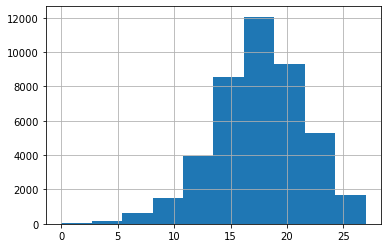

In [44]:
recent_tracks_df['total_follower_count'] = recent_tracks_df.apply(get_total_followers, axis=1)
recent_tracks_df = recent_tracks_df.query('total_follower_count > 0')
recent_tracks_df['log_total_follower_count'] = np.log2(recent_tracks_df['total_follower_count'])
recent_tracks_df['log_total_follower_count'].hist()

In [47]:
recent_tracks_df.head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,top_200_presence,total_follower_count,log_total_follower_count
39529,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,26,187333,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.319,0.201,...,0.0623,0.887,0.000000,0.9040,0.239,117.153,3,False,4677919.0,22.157435
39533,19oquvXf3bc65GSqtPYA5S,It Was A Very Good Year - Live At The Sands Ho...,25,236800,0,['Frank Sinatra'],['1Mxqyy3pSjf8kZZL4QVxS0'],2018-05-04,0.269,0.129,...,0.0576,0.938,0.000005,0.6830,0.160,82.332,3,False,4677919.0,22.157435
39581,55qyghODi24yaDgKBI6lx0,"The Circle Game - Live at The 2nd Fret, Philad...",18,313093,0,['Joni Mitchell'],['5hW4L92KnC6dX9t7tYM4Ve'],2020-10-30,0.644,0.212,...,0.0347,0.881,0.000022,0.7980,0.441,117.072,3,False,971124.0,19.889296
39583,00xemFYjQNRpOlPhVaLAHa,"Urge For Going - Live at The 2nd Fret, Philade...",18,295093,0,['Joni Mitchell'],['5hW4L92KnC6dX9t7tYM4Ve'],2020-10-30,0.627,0.184,...,0.0450,0.955,0.000162,0.0986,0.299,115.864,4,False,971124.0,19.889296
39585,26g4FBGTB9YEj7q4HlblFf,"Brandy Eyes - Live at The 2nd Fret, Philadelph...",17,147907,0,['Joni Mitchell'],['5hW4L92KnC6dX9t7tYM4Ve'],2020-10-30,0.442,0.399,...,0.0780,0.930,0.000499,0.9120,0.554,121.662,4,False,971124.0,19.889296


207888
204688
28897
1570


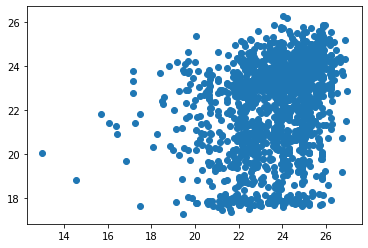

In [67]:
## Merge release_date into charts_df using track_id

recent_tracks_df_merging = recent_tracks_df[['id', 'release_date']]

merge_rel_date = pd.merge(top_200_charts_US, recent_tracks_df_merging, left_on='track_id', right_on='id')

merge_rel_date['date'] = pd.to_datetime(merge_rel_date['date'])
merge_rel_date['release_date'] = pd.to_datetime(merge_rel_date['release_date'])

merge_rel_date['days_since_release'] = ((merge_rel_date['date'] - merge_rel_date['release_date']) / np.timedelta64(1,'m'))/1440

print(len(merge_rel_date))

merge_rel_date = merge_rel_date.query('days_since_release > 0')

print(len(merge_rel_date))

charts_within_30_days_of_release = merge_rel_date.query('days_since_release <= 30')
print(len(charts_within_30_days_of_release))

Num_streams_by_ID = charts_within_30_days_of_release.groupby('track_id', as_index=False)['streams'].sum()
print(len(Num_streams_by_ID))

recent_tracks_df_w_streams = pd.merge(recent_tracks_df, Num_streams_by_ID, left_on='id', right_on='track_id')

recent_tracks_df_w_streams['log_artist_streams'] = np.log2(recent_tracks_df_w_streams['streams'])

top_200_recent_tracks_only = recent_tracks_df_w_streams.query('streams > 0')

plt.scatter(top_200_recent_tracks_only['log_total_follower_count'], top_200_recent_tracks_only['log_artist_streams'])